In [1]:
import nibabel as nib
import numpy as np

In [127]:
#prepare arrays:

func_array = np.load("sub-60033_diff_wm_2vol_ts_1vol.npy")
func_array.shape
func_array = np.expand_dims(func_array, axis=1)
func_array.shape
func_array = np.expand_dims(func_array, axis=2)
func_array.shape

conn_array = np.loadtxt("association_matrix_sub-60033.csv",
                 delimiter=",", dtype=float)
conn_array.shape
conn_array = np.expand_dims(conn_array, axis=2)
conn_array.shape
conn_array = np.expand_dims(conn_array, axis=3)
conn_array.shape


(454, 454, 1, 1)

In [124]:
func_array.shape

(454, 1, 1)

In [128]:
import numpy as np
from scipy.stats import ttest_1samp
import h5py

# Assuming taskActMatrix and connMatrix are numpy arrays
taskActMatrix = func_array #shape parcel x ts x subj
connMatrix = conn_array # shape parcel x parcel x state x subj

numTasks = taskActMatrix.shape[1]
numRegions = taskActMatrix.shape[0]
numConnStates = connMatrix.shape[2]
numSubjs = connMatrix.shape[3]

# Setup for prediction
taskPredMatrix = np.zeros((numRegions, numTasks, numSubjs))
taskPredRs = np.zeros((numTasks, numSubjs))
taskActualMatrix = taskActMatrix
regionNumList = np.arange(numRegions)

In [ ]:
import ActflowToolbox as actflow
restFC_corr=connMatrix
scount=0

restFC_corr[:,:,scount]=actflow.connectivity_estimation.corrcoefconn(connMatrix[:,:,scount])

print("==Activity flow mapping results, correlation-based resting-state FC, 24 task conditions==")
actflowOutput_restFCCorr_bycond = actflow.actflowcomp.actflowtest(taskActMatrix, restFC_corr)

In [130]:
import scipy
import matplotlib
for subjNum in range(numSubjs):
    for taskNum in range(numTasks):

        # Get this subject's activation pattern for this task
        taskActVect = taskActMatrix[:, taskNum, subjNum]

        for regionNum in range(numRegions):

            # Hold out region whose activity is being predicted
            otherRegions = np.delete(regionNumList, regionNum)

            # Get this region's connectivity pattern
            if numConnStates > 1:
                stateFCVect = connMatrix[:, regionNum, taskNum, subjNum]
            else:
                # If using resting-state (or any single state) data
                stateFCVect = connMatrix[:, regionNum, 0, subjNum]

            # Calculate activity flow prediction
            taskPredMatrix[regionNum, taskNum, subjNum] = np.sum(taskActVect[otherRegions] * stateFCVect[otherRegions])
        # Normalize values (z-score)
        taskPredMatrix[:, taskNum, subjNum] = (taskPredMatrix[:, taskNum, subjNum] - np.mean(taskPredMatrix[:, taskNum, subjNum])) / np.std(taskPredMatrix[:, taskNum, subjNum])
        taskActualMatrix[:, taskNum, subjNum] = (taskActMatrix[:, taskNum, subjNum] - np.mean(taskActMatrix[:, taskNum, subjNum])) / np.std(taskActMatrix[:, taskNum, subjNum])

        # Calculate predicted to actual similarity for this task
        r = np.corrcoef(taskPredMatrix[:, taskNum, subjNum], taskActualMatrix[:, taskNum, subjNum])
        taskPredRs[taskNum, subjNum] = r[0, 1]
        
# Calculate average r, across-subject p-value
r_bytask = np.tanh(np.mean(np.arctanh(taskPredRs), axis=1))
p_bytask = np.ones(numTasks)
for taskNum in range(numTasks):
    _, p_bytask[taskNum] = ttest_1samp(np.arctanh(taskPredRs[taskNum, :]), 0)

r_overall = np.tanh(np.mean(np.arctanh(taskPredRs)))  

_, p_overall = ttest_1samp(np.mean(np.arctanh(taskPredRs), axis=0), 0) 

# By subject
r_bysubj = taskPredRs
t_overall = ttest_1samp(np.mean(np.arctanh(taskPredRs), axis=0), 0)[0]  

# Calculate average-then-compare results
r_avgfirst_bytask = np.zeros(numTasks)
for taskNum in range(numTasks):
    r_avgfirst_bytask[taskNum] = np.corrcoef(np.mean(taskPredMatrix[:, taskNum, :], axis=1), np.mean(taskActualMatrix[:, taskNum, :], axis=1))[0, 1]
    spearman_corr =scipy.stats.spearmanr (taskPredMatrix[:, taskNum, 0], taskActualMatrix[:, taskNum, 0])[0]
    r_avgfirst_bytask[taskNum] = spearman_corr

r_avgfirst_mean = np.tanh(np.mean(np.arctanh(r_avgfirst_bytask)))


spearman: 0.03565221113917547
pearson: [1.         0.09525789]


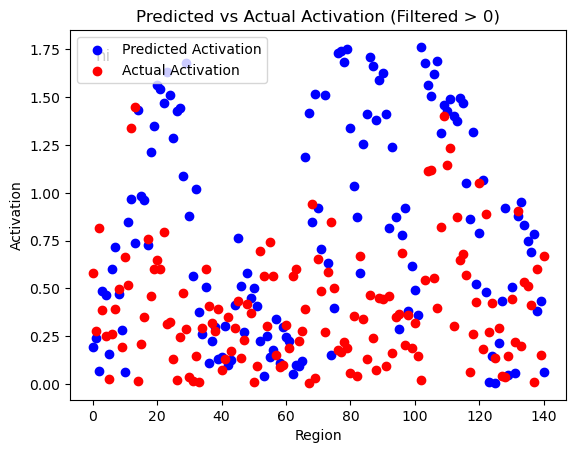

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, spearmanr

# Assuming taskPredRs, taskPredMatrix, and taskActualMatrix are already defined
numTasks = taskPredMatrix.shape[1]
numRegions = taskPredMatrix.shape[0]

# Calculate average r, across-subject p-value
r_bytask = np.tanh(np.mean(np.arctanh(taskPredRs), axis=1))
p_bytask = np.ones(numTasks)
for taskNum in range(numTasks):
    _, p_bytask[taskNum] = ttest_1samp(np.arctanh(taskPredRs[taskNum, :]), 0)

r_overall = np.tanh(np.mean(np.arctanh(taskPredRs)))
_, p_overall = ttest_1samp(np.mean(np.arctanh(taskPredRs), axis=1), 0)

# By subject
r_bysubj = taskPredRs
t_overall = ttest_1samp(np.mean(np.arctanh(taskPredRs), axis=1), 0)[0]

# Calculate average-then-compare results for one subject
r_avgfirst_bytask = np.zeros(numTasks)
for taskNum in range(numTasks):
    # Assuming data is for one subject
    spearman_corr = spearmanr(taskPredMatrix[:, taskNum, 0], taskActualMatrix[:, taskNum, 0])[0]
    r = np.corrcoef(taskPredMatrix[:, taskNum, 0], taskActualMatrix[:, taskNum, 0])[0]
    
    r_avgfirst_bytask[taskNum] = spearman_corr

r_avgfirst_mean = np.tanh(np.mean(np.arctanh(r_avgfirst_bytask)))

# Plot scatter plots for each task with different colors for predicted and actual values
for taskNum in range(numTasks):
    # Filter values greater than zero
    pred_values = taskPredMatrix[:, taskNum, 0]
    actual_values = taskActualMatrix[:, taskNum, 0]
    mask = (pred_values > 0) & (actual_values > 0)
    
    filtered_pred_values = pred_values[mask]
    filtered_actual_values = actual_values[mask]
    spearman_corr = spearmanr(filtered_pred_values, filtered_actual_values)[0]
    r = np.corrcoef(filtered_pred_values, filtered_actual_values)[0]
    print('spearman:', spearman_corr)
    print('pearson:', r)

    plt.figure()
    plt.scatter(range(len(filtered_pred_values)), filtered_pred_values, color='blue', label='Predicted Activation')
    plt.scatter(range(len(filtered_actual_values)), filtered_actual_values, color='red', label='Actual Activation')
    plt.title('Predicted vs Actual Activation (Filtered > 0)')
    plt.xlabel('Region')
    plt.ylabel('Activation')
    #spearman_corr = spearmanr(filtered_pred_values, filtered_actual_values)[0]
    plt.text(0.05, 0.95, s='hi', transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top')
    plt.legend()
    plt.show()


In [116]:
print(spearman_corr)

0.03565221113917547


In [117]:
print(taskPredRs)

[[0.00846382]]
